In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import glob

mpl.rcParams['figure.figsize'] = (5,5)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

In [2]:
model_name = "v14_finalscore"
model_dir = "../models/"+model_name
det = "EE"
model_version = 6
numpy_version = 17
limit_files = 10
cols = ["seed_eta", "seed_phi", "seed_iz","en_seed","et_seed",
        "cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
       "seed_f5_r9", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi",
        "seed_f5_swissCross","seed_nxtals", "seed_etaWidth", "seed_phiWidth",
        "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi",
        "cl_f5_swissCross", "cl_nxtals", "cl_etaWidth", "cl_phiWidth"]

os.makedirs(model_dir, exist_ok = True)
with open("variables.txt", "w") as of:
    of.write("\n".join(cols))

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [3]:
files_ele = f"/storage/ECAL/training_data/electrons/numpy_v{numpy_version}/training/"
files_gamma = f"/storage/ECAL/training_data/gammas/numpy_v{numpy_version}/training/"

In [4]:
datas_ele = []

i = 0
for f in glob.glob(files_ele+"*.pkl"):
    if i>limit_files :continue
    d = pickle.load(open(f, "rb"))   
    datas_ele.append(d[d.is_seed == False])
    i+=1
    
data_ele = pd.concat(datas_ele, ignore_index=True)
data_ele["particle"] = "electron"
print("N events ele: ",len(data_ele))

datas_gamma = []
i = 0
for f in glob.glob(files_gamma+"*.pkl"):
    if i>limit_files :continue
    d = pickle.load(open(f, "rb"))  
    datas_gamma.append(d[d.is_seed==False])
    i+=1
    
data_gamma = pd.concat(datas_gamma, ignore_index=True)
data_gamma["particle"] = "gamma"
print("N events gamma: ",len(data_gamma))

if data_ele.shape[0]> data_gamma.shape[0]:
    data = pd.concat([data_gamma, data_ele.iloc[0:len(data_gamma)]], ignore_index=True)
else:
    data = pd.concat([data_gamma.iloc[0:len(data_ele)], data_ele], ignore_index=True)
    
del data_gamma
del data_ele

N events ele:  5151947
N events gamma:  4983806


Balance gamma and electron

In [5]:
data_EB = data[data.seed_iz == 0]
data_EE = data[data.seed_iz != 0]

In [7]:
print("Sample in EB:", len(data[abs(data.seed_eta) <1.479]))
print("Sample in EE:", len(data[abs(data.seed_eta) >=1.479]))
print("Sample in EB in SC:", len(data[(abs(data.seed_eta) <1.479)&(data.in_scluster)]))
print("Sample in EE in SC:", len(data[(abs(data.seed_eta) >=1.479)&(data.in_scluster)]))
print("N in supercluster: ", len(data[ data.in_scluster]))
print("N out supercluster: ", len(data[data.in_scluster == False]))
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print(w)

Sample in EB: 7404622
Sample in EE: 2562990
Sample in EB in SC: 430788
Sample in EE in SC: 182582
N in supercluster:  613370
N out supercluster:  9354242
15.250569802892219


In [8]:
print("caloMatch samples: ", len(data[data.is_calo_matched]))
print("Not caloMatch samples: ", len(data[data.is_calo_matched ==False]))

caloMatch samples:  1640662
Not caloMatch samples:  8326950


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


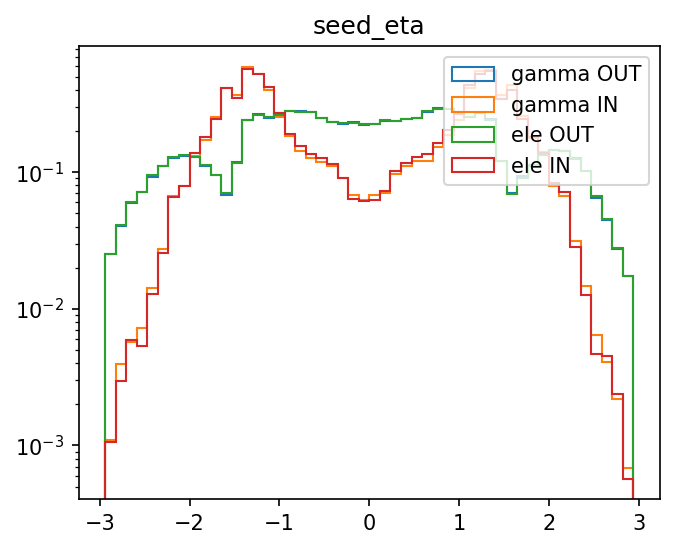

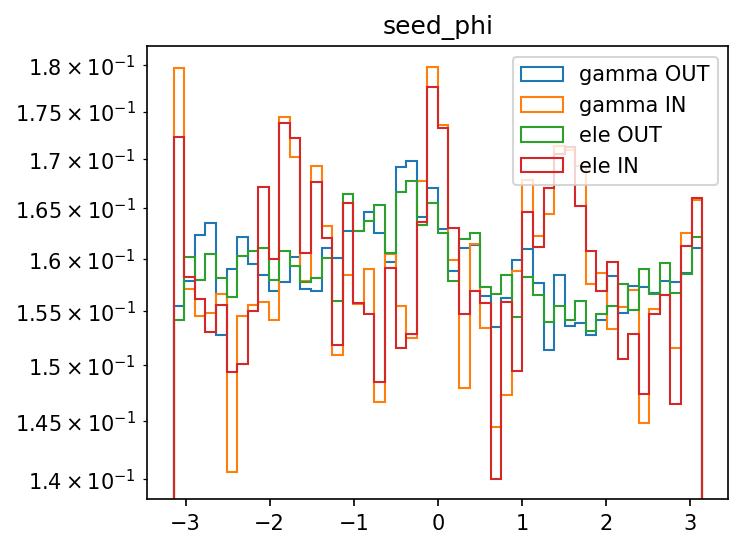

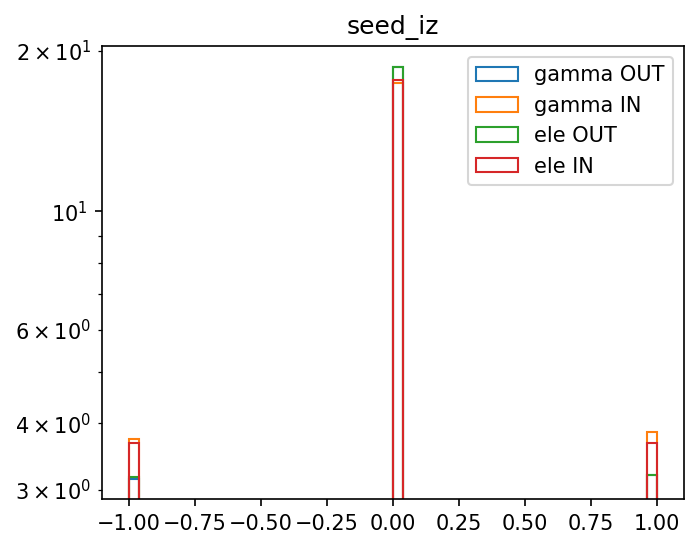

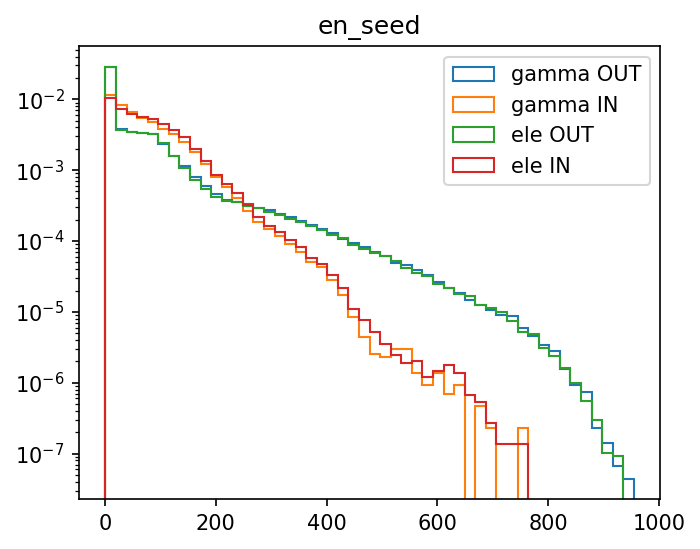

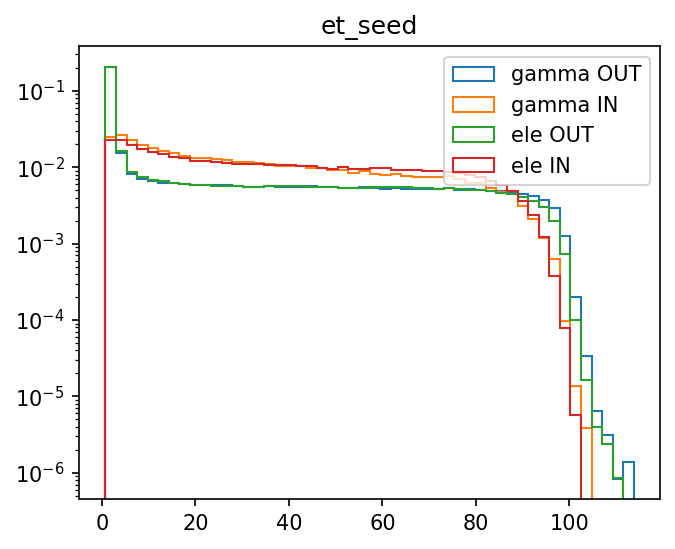

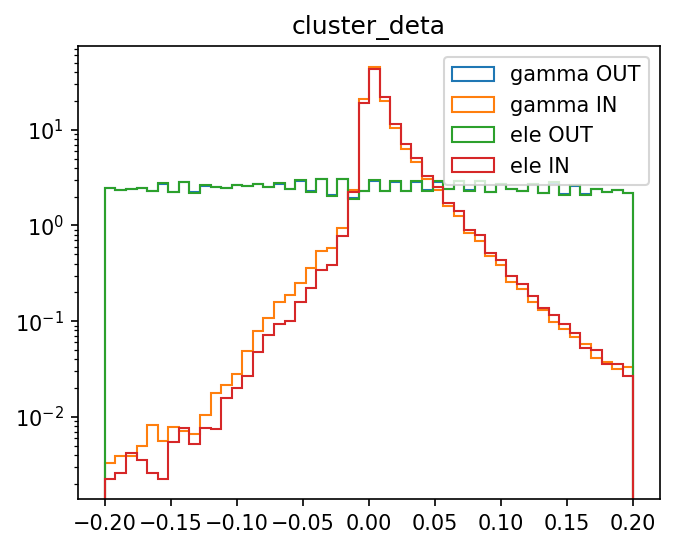

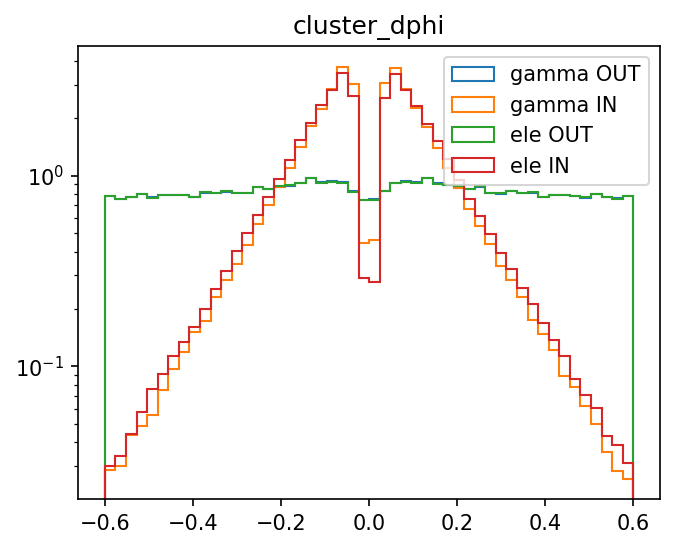

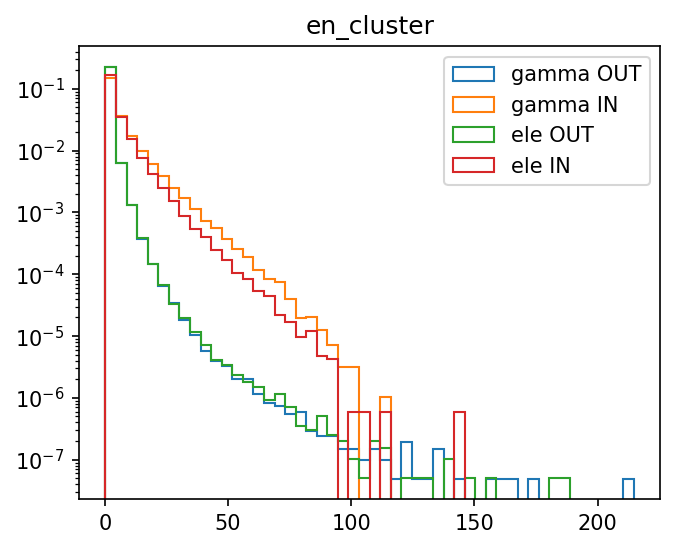

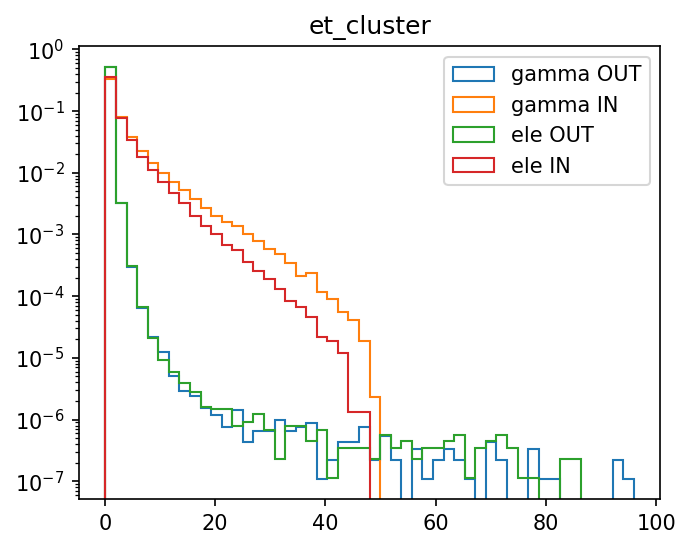

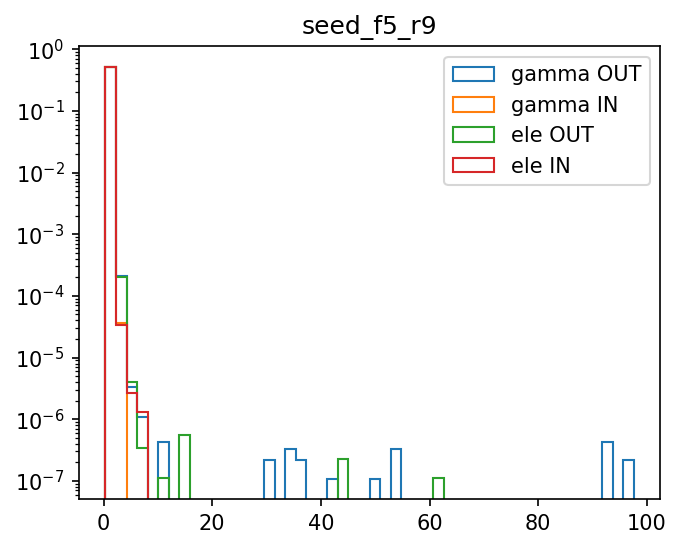

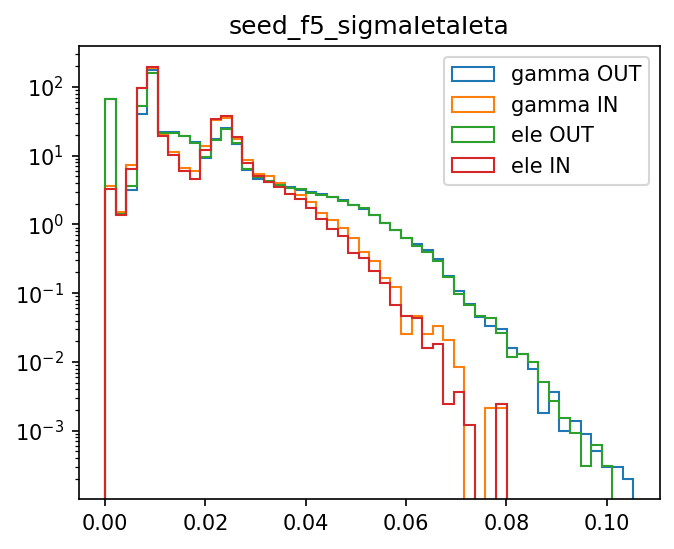

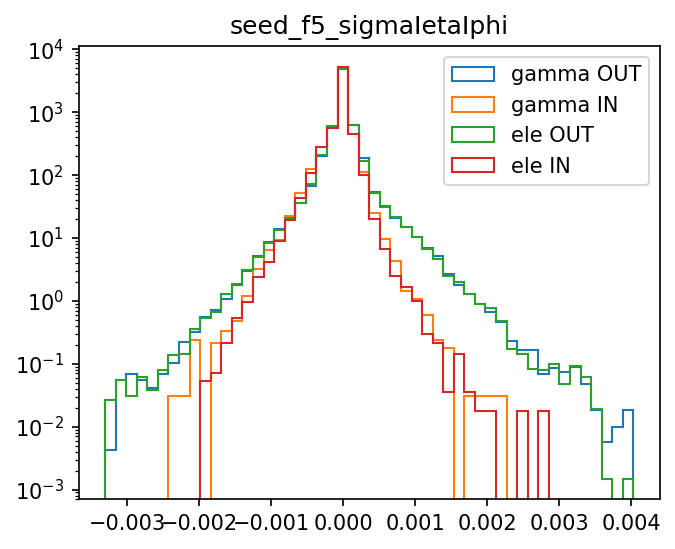

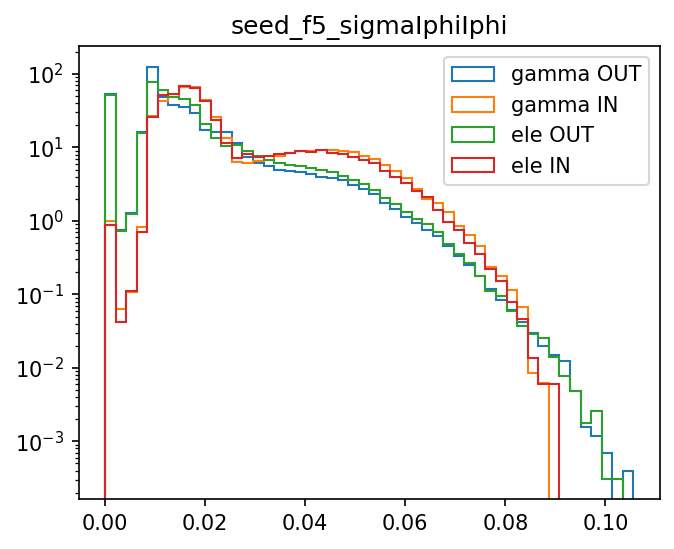

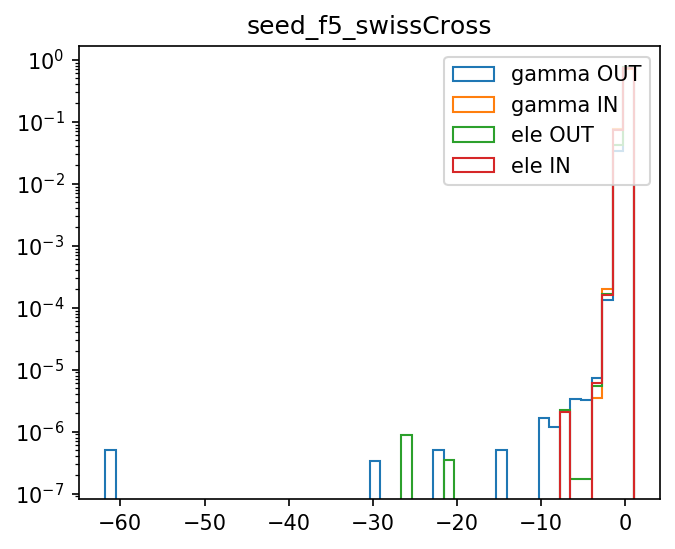

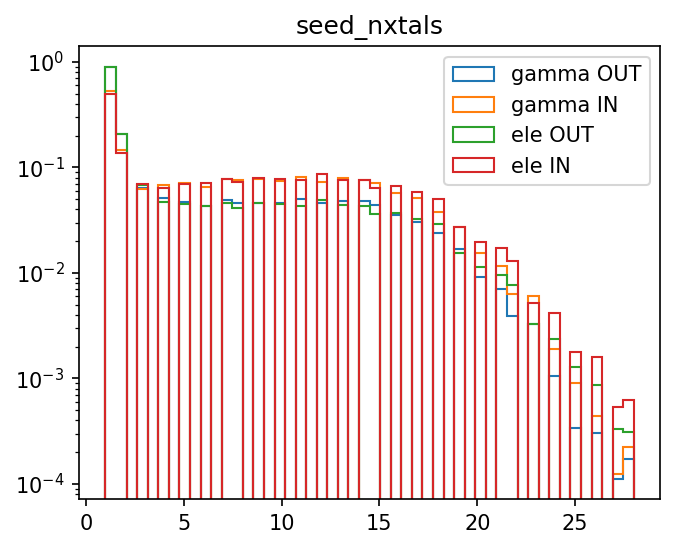

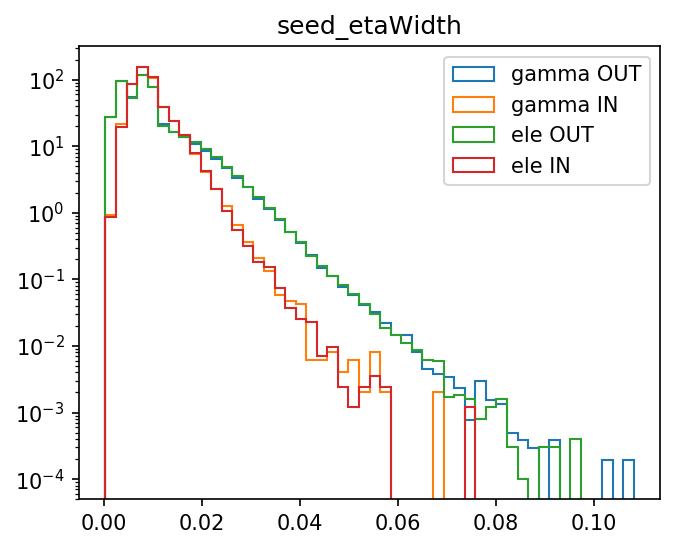

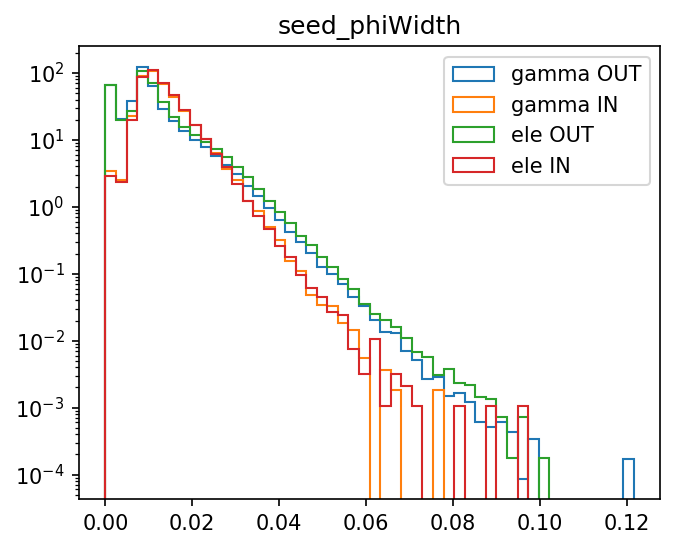

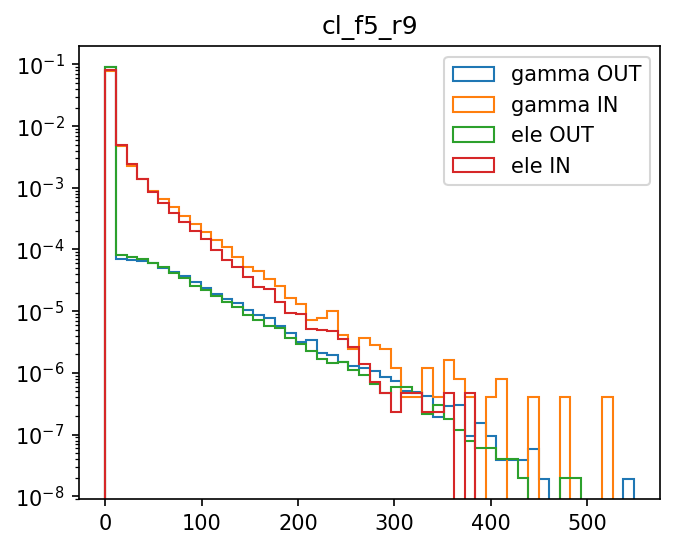

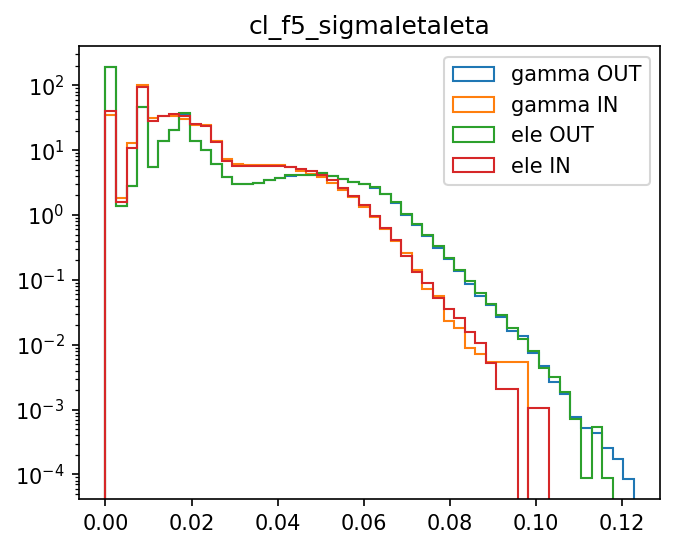

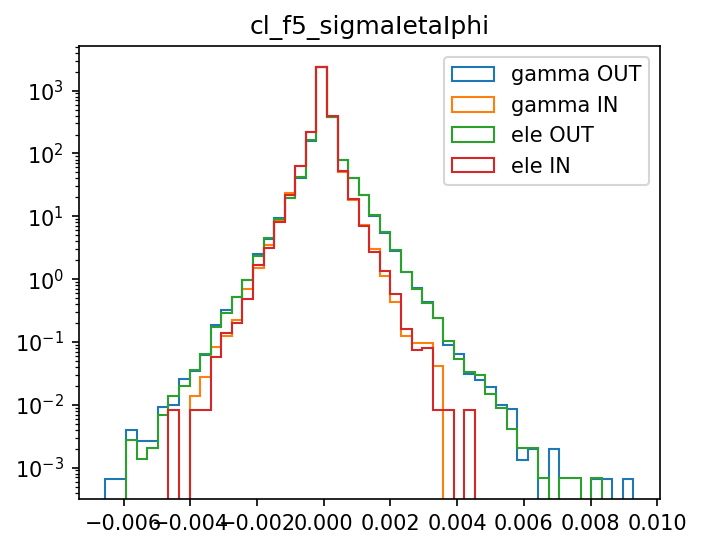

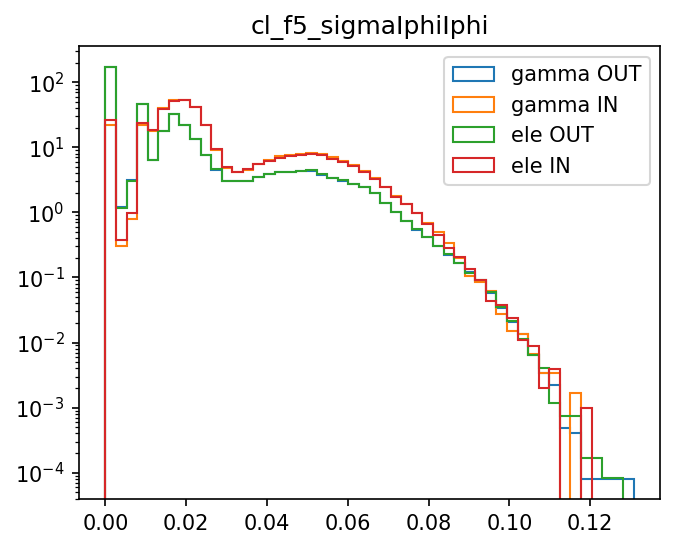

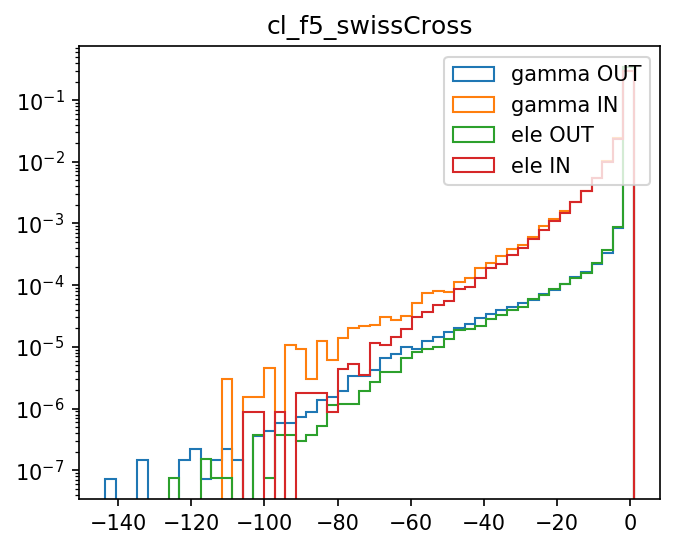

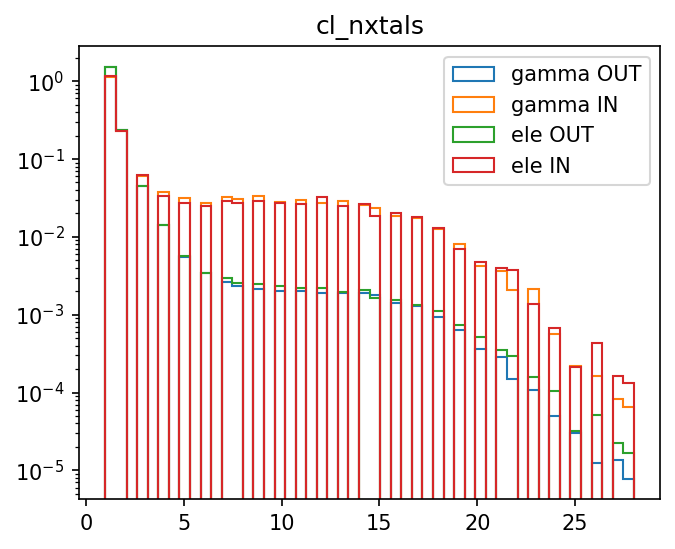

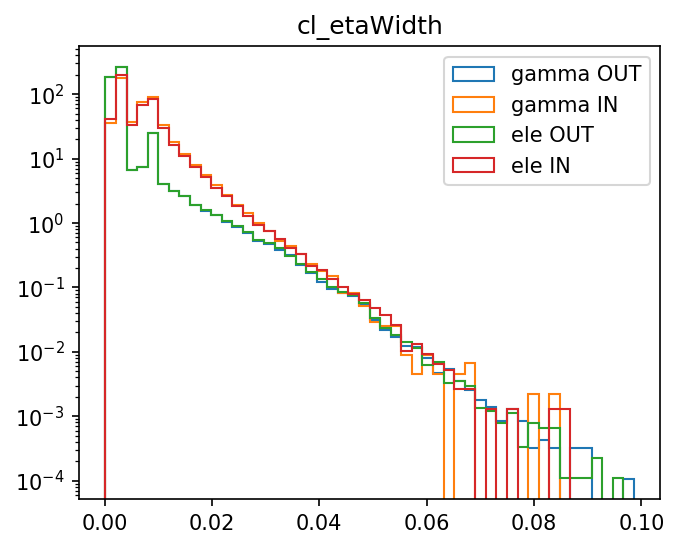

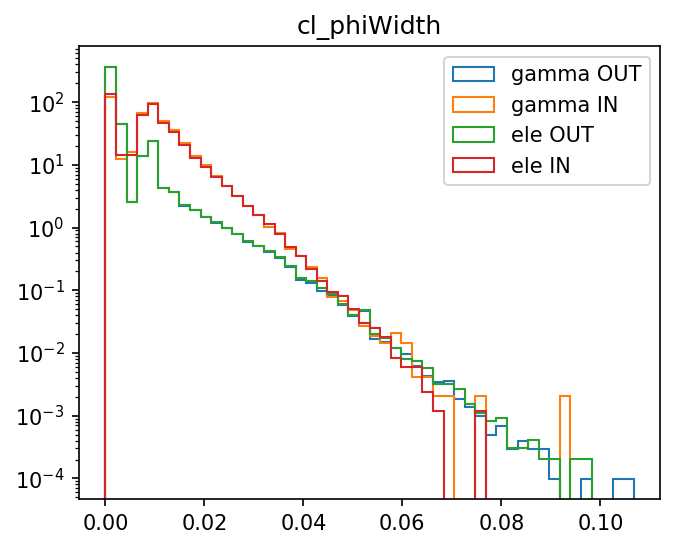

In [24]:
for col in cols:
    f = plt.figure()
    a = plt.hist(data[(data.particle=="gamma")&(data.in_scluster==False) ][col], histtype="step",
                 density=True, bins=50,label="gamma OUT")
    
    plt.hist(data[(data.particle=="gamma")&(data.in_scluster) ][col], histtype="step",
                 density=True, bins=50,label="gamma IN",range=(a[1][0], a[1][-1]))
    
    plt.hist(data[(data.particle=="electron")&(data.in_scluster == False) ][col], histtype="step", 
                 density=True, bins=50,label="ele OUT", range=(a[1][0], a[1][-1]))
    
    plt.hist(data[(data.particle=="electron")&(data.in_scluster) ][col], histtype="step", 
                 density=True, bins=50,label="ele IN", range=(a[1][0], a[1][-1]))
    plt.yscale("log")
    plt.title(col)
    plt.legend()
    plt.savefig(model_dir+"/input_classes_{}.png".format(col))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


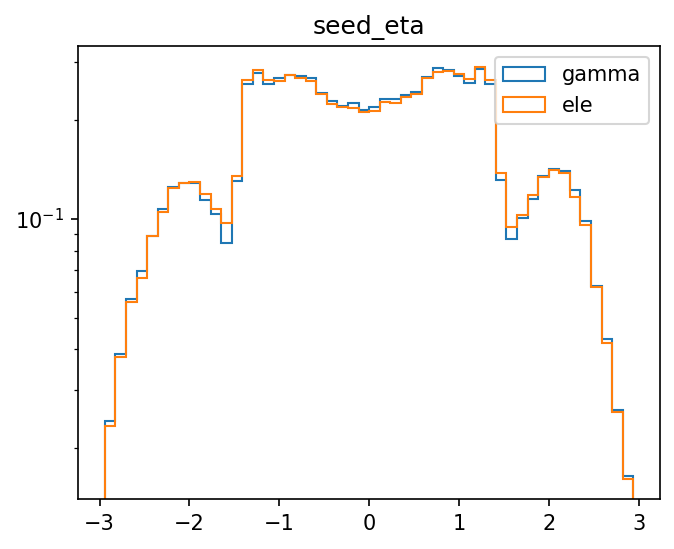

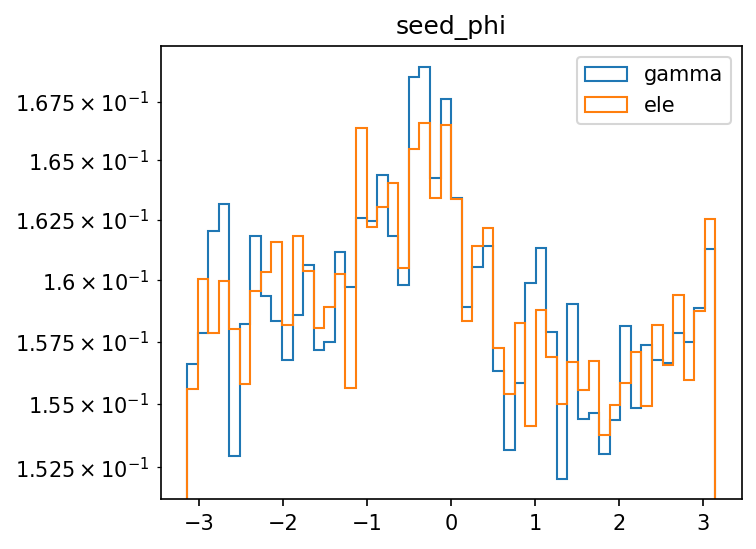

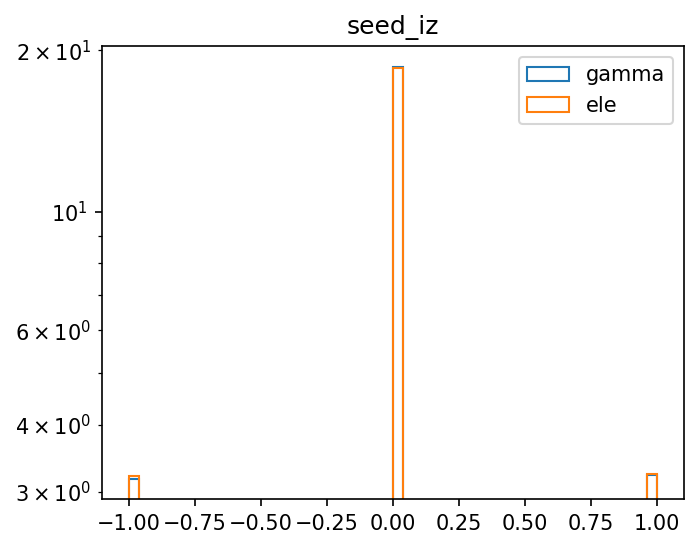

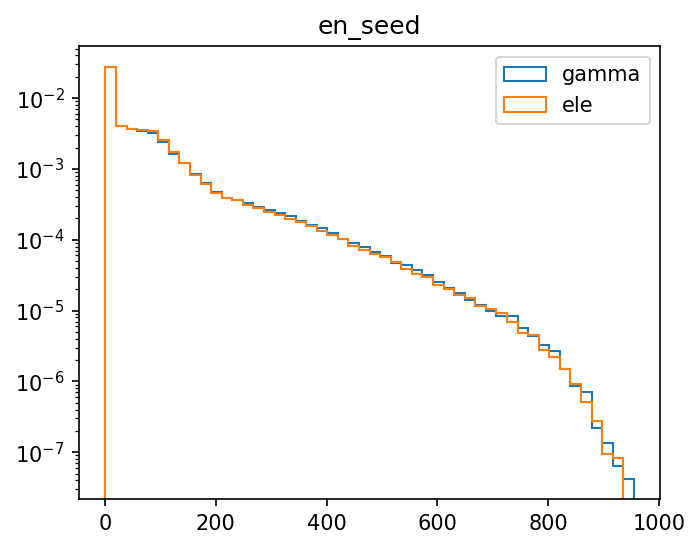

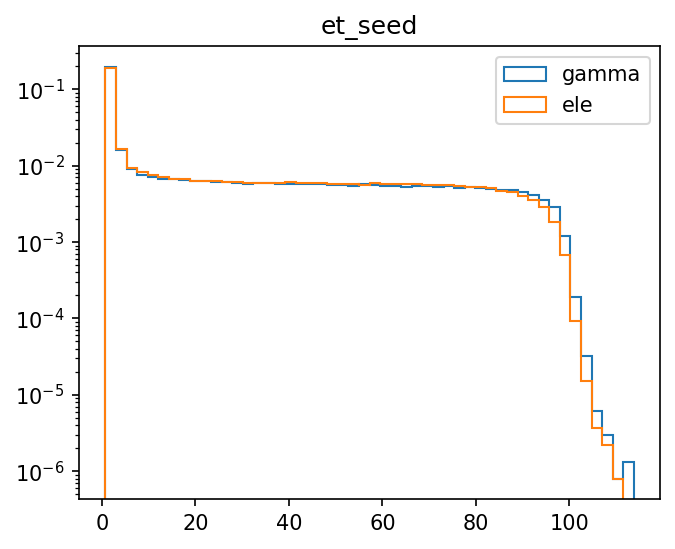

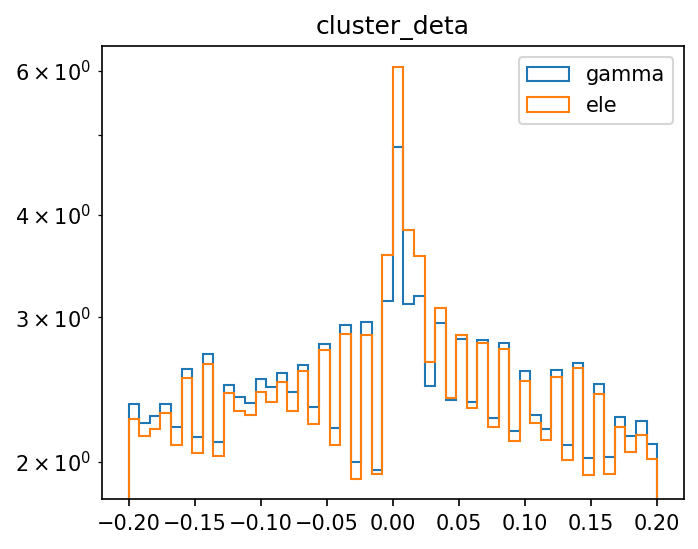

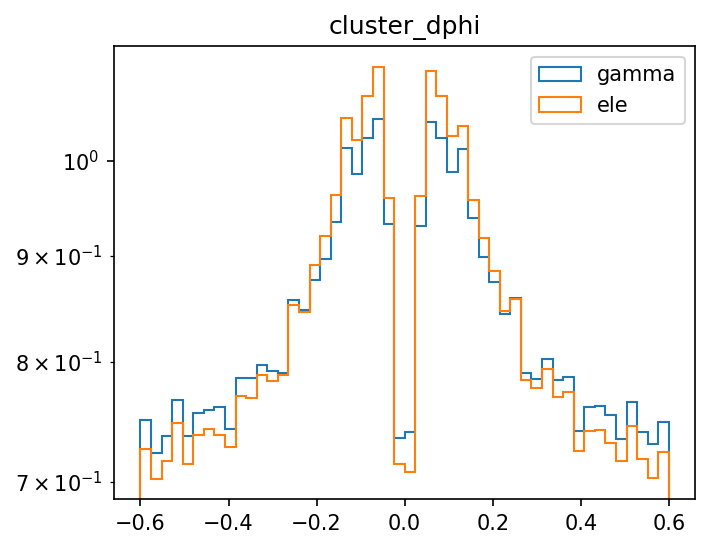

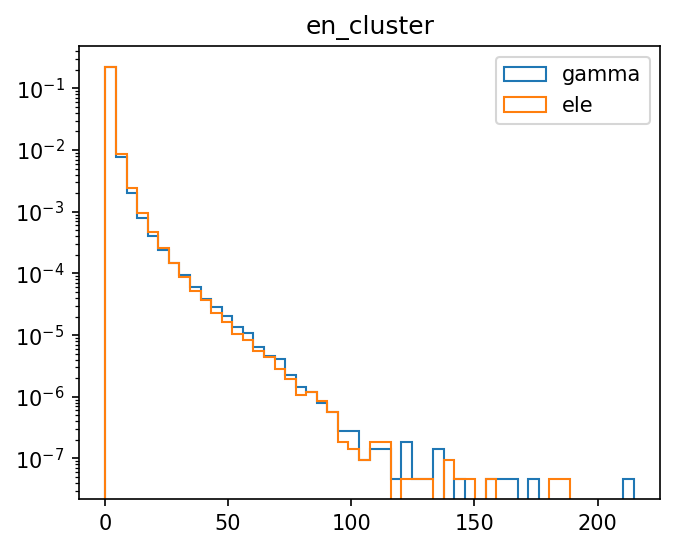

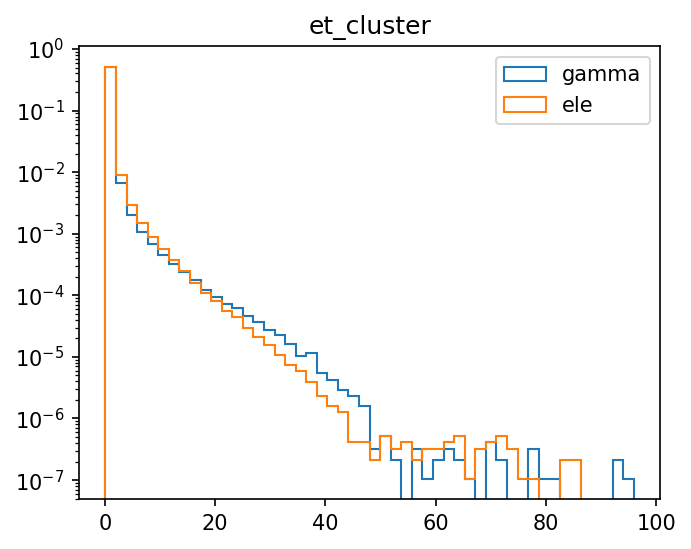

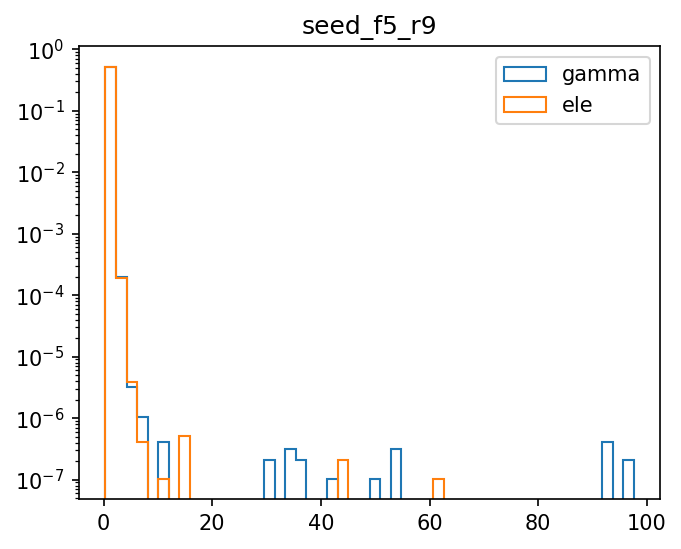

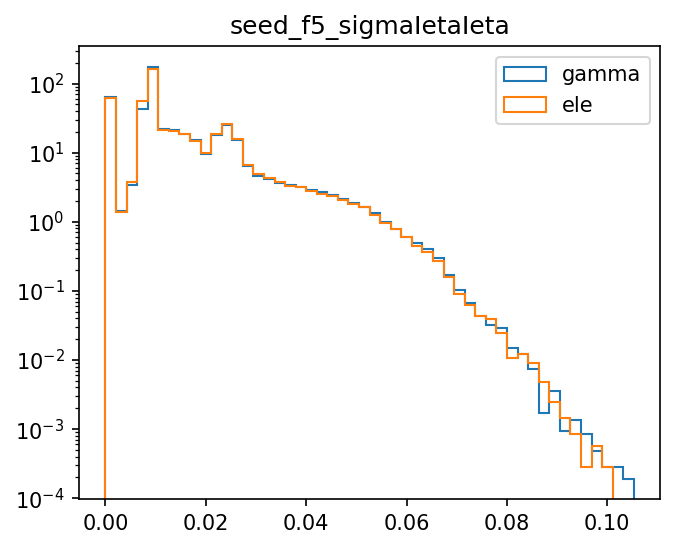

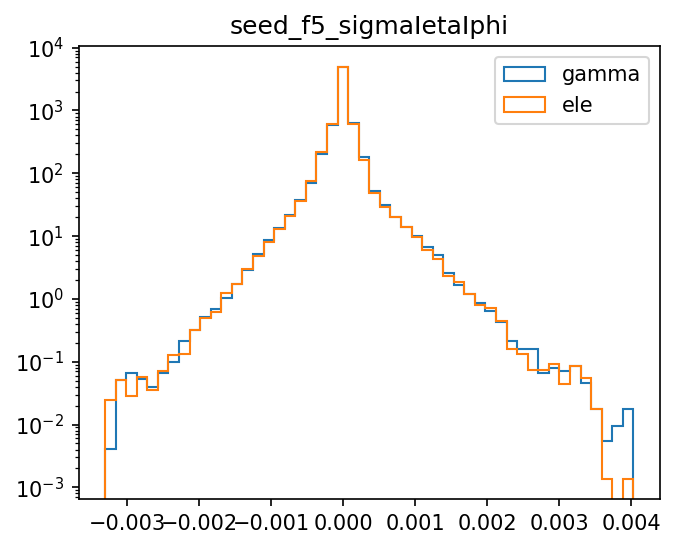

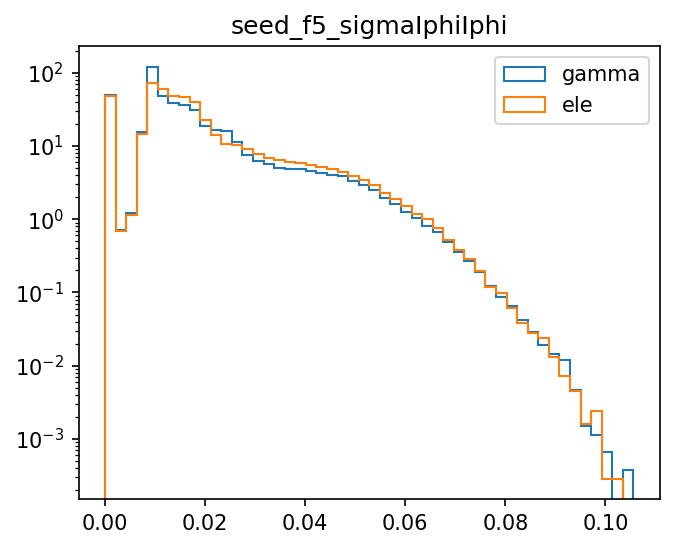

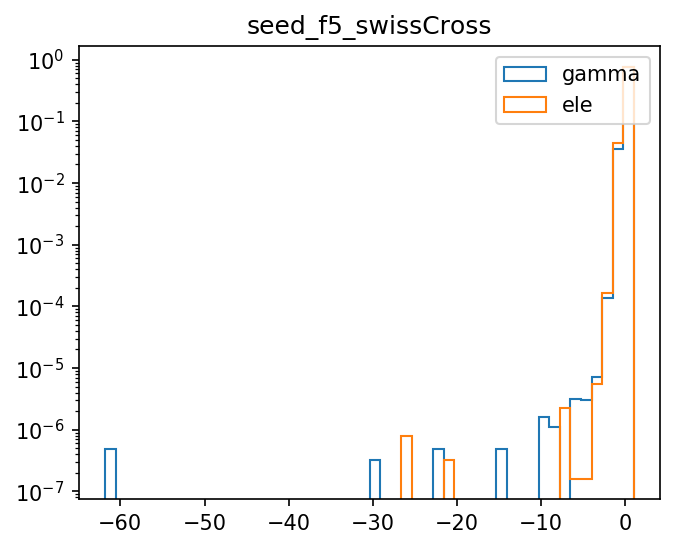

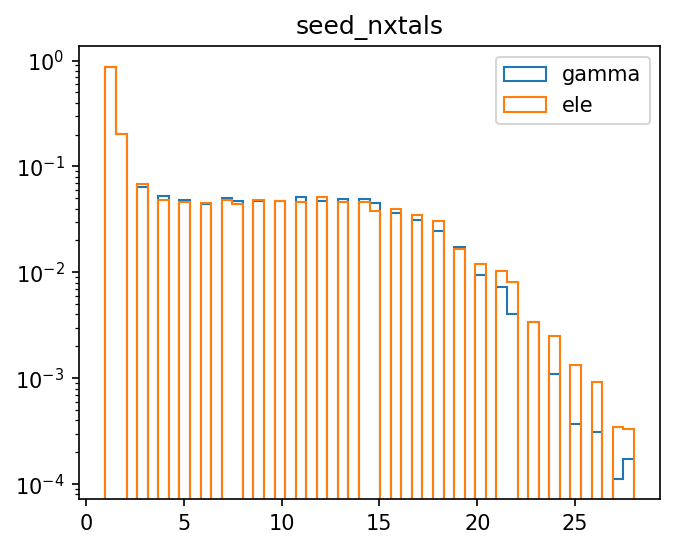

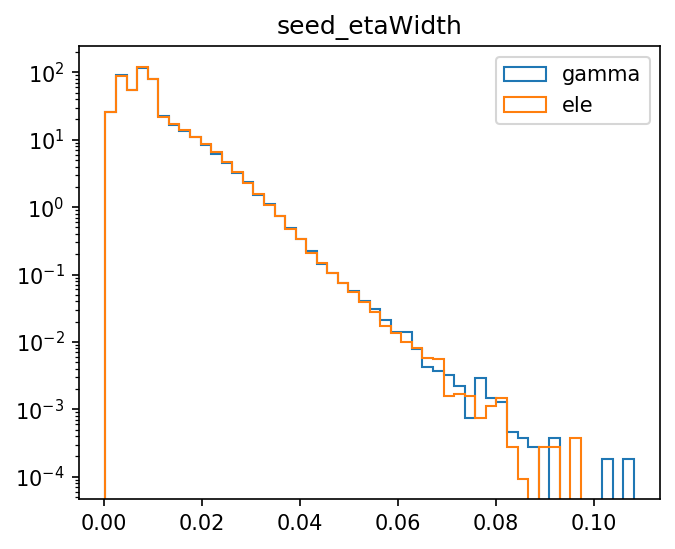

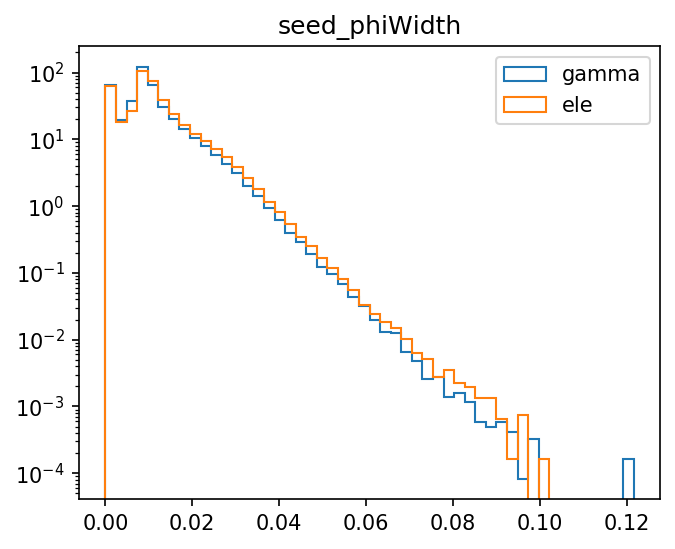

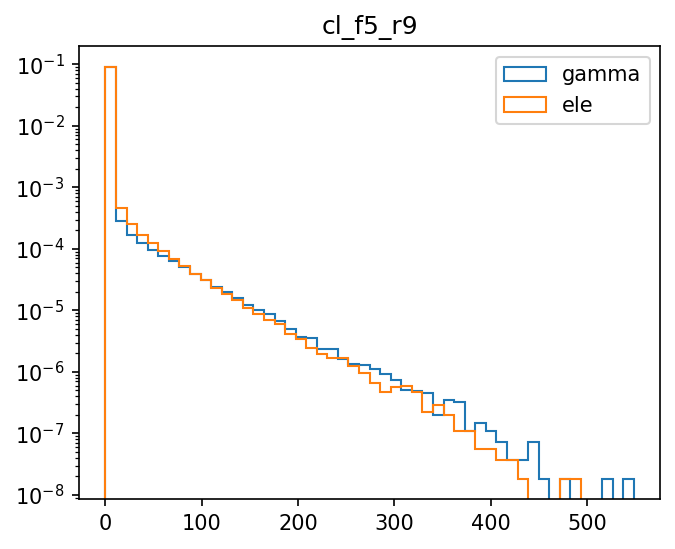

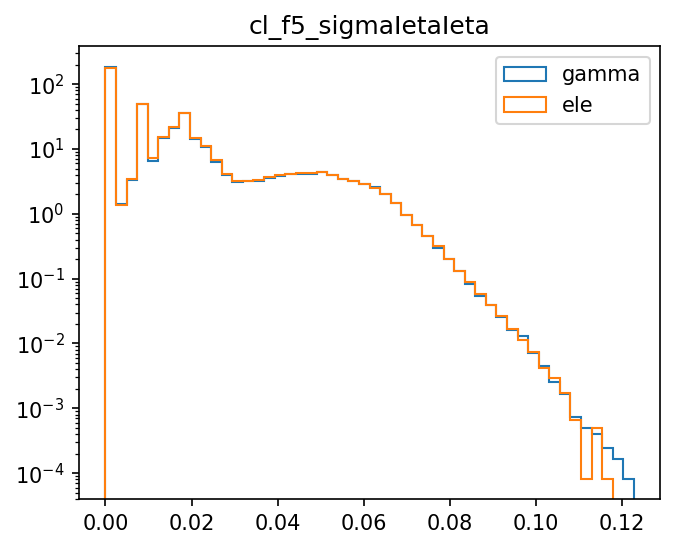

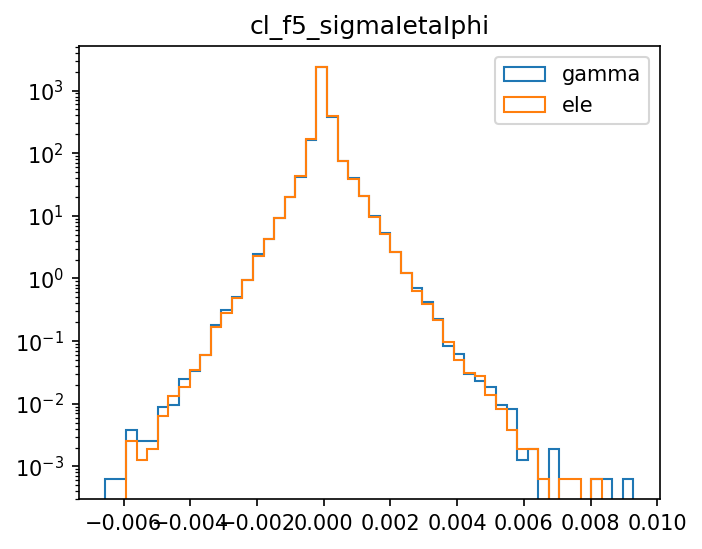

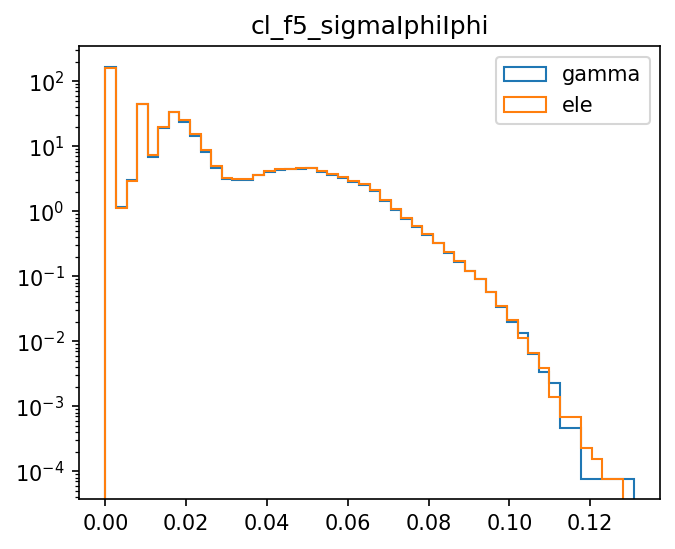

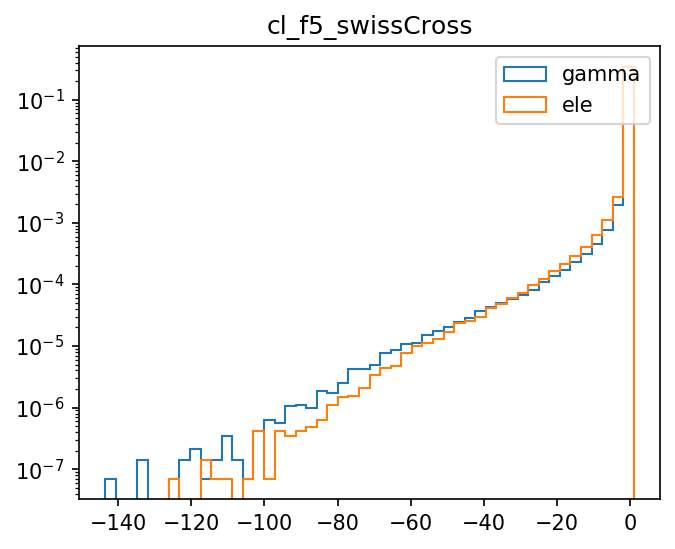

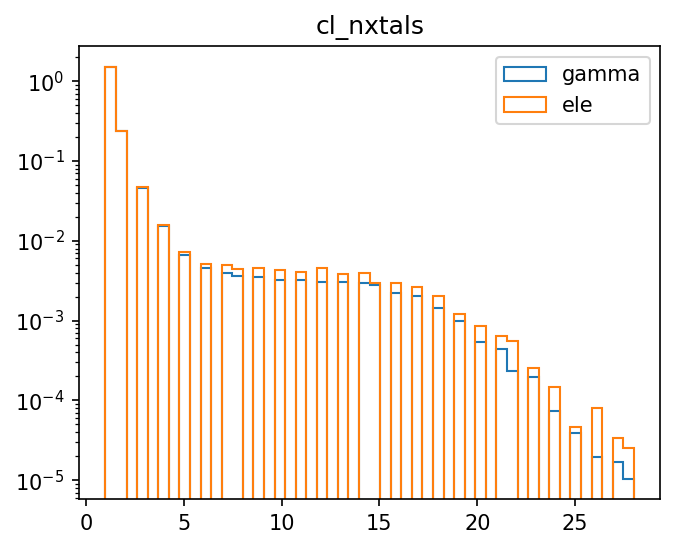

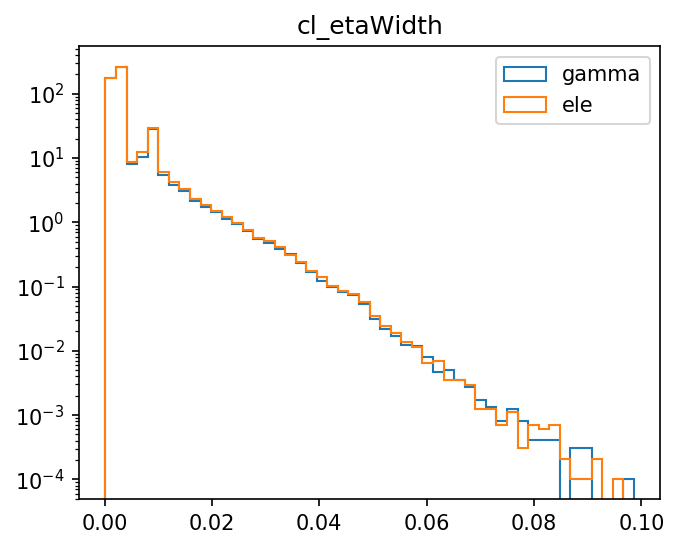

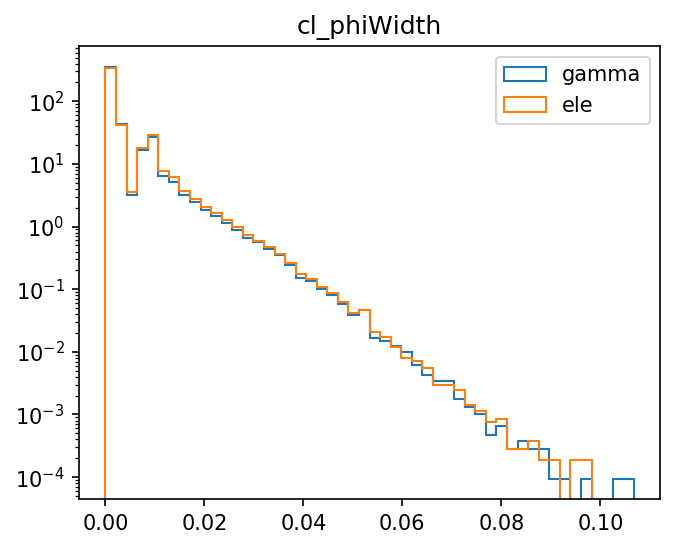

In [25]:
for col in cols:
    f = plt.figure()
    a = plt.hist(data[data.particle=="gamma"][col], histtype="step",
                 density=True, bins=50,label="gamma")
    plt.hist(data[data.particle=="electron"][col], histtype="step", 
                 density=True, bins=50,label="ele", range=(a[1][0], a[1][-1]))
    plt.yscale("log")
    plt.title(col)
    plt.legend()
    plt.savefig(model_dir+"/input_{}.png".format(col))

# Data Preparation

In [6]:
if det == "EB":
    data = data_EB
if det == "EE":
    data = data_EE

In [7]:
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print("Weight ",w)
data.loc[data.in_scluster,"w"] = w
data.loc[data.in_scluster==False, "w"] = 1.

Weight  13.037473573517651


In [8]:
X = data[ cols ].values
truth = data[["in_scluster"]].values
y = np.array(truth[:], dtype=int)
weights = data.w.values

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = pickle.load(open(model_dir + "/scaler_model_v{}_{}.pkl".format(model_version,det), "rb"))

X_scaled = scaler.fit_transform(X)

In [15]:
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_scaled, y, weights, test_size=0.10)

### ANOVA

In [14]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, f_classif

import itertools

## This uses only public API, but is a real mess
#mask = [False for i in range (len(config["cols"]))]
#for varn  in range (len(config["cols"]) + 1):
#    a = SelectKBest(f_classif, k=varn)
#    a.fit(X_train, y_train)
#    mask_old = mask.copy()
#    mask = a.get_support()
#    mask_xor = [x ^ y for x,y in zip(mask, mask_old)]
#    print(varn, list(itertools.compress( config["cols"], mask_xor )))
        
## This uses a SelectKBest "private" member, but is faster and cleaner
selection = SelectKBest(f_classif, k=4)
selection.fit(X_train, y_train)
scores_df = pd.DataFrame({"score": selection.scores_, "varname": cols})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<BarContainer object of 25 artists>

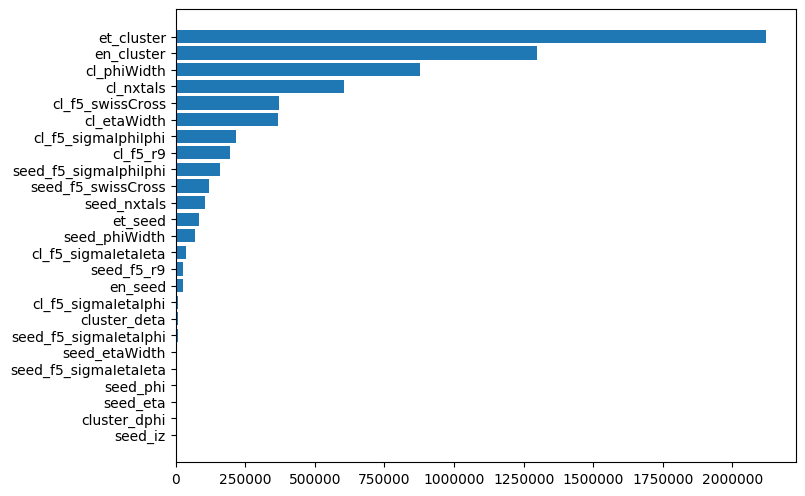

In [15]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

## visualize scores as barchart
s_df = scores_df.sort_values(by=["score"], ascending=True)
plt.barh(range(len(s_df["score"])), s_df["score"], tick_label=s_df["varname"])

### SHAP

In [27]:
!pip3 install --user --upgrade shap

     |████████████████████████████████| 276kB 4.9MB/s eta 0:00:01
     |████████████████████████████████| 71kB 1.4MB/s  eta 0:00:01
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=395275 sha256=1adb4269b1a2b3195effcb265077657c84c14608846dfc8d05a550c70e6ad693
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [22]:
import tensorflow as tf

model = tf.keras.models.load_model(os.path.join(model_dir, "model_v{}_{}.hd5".format(model_version, det)))

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 200)               5200      
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

In [20]:
import shap

shap.initjs()

In [16]:
index1 = [x for x in range(len(X_train))]
X_train_pd = pd.DataFrame(X_train, index=index1, columns=cols)
index2 = [x for x in range(len(X_train), len(X_train) + len(X_val))]
X_val_pd = pd.DataFrame(X_val, index=index2, columns=cols)

In [17]:
X_train_pd.values

array([[ 1.18064962, -1.4270171 ,  0.99427388, ...,  0.5394538 ,
        -0.44046737, -0.46928359],
       [ 0.76450166, -0.4289648 ,  0.99427388, ..., -0.30853858,
        -0.54906247, -0.4754594 ],
       [ 1.1310163 , -0.65108179,  0.99427388, ...,  0.96344999,
        -0.35052466, -0.47572918],
       ...,
       [-0.88348588, -0.6440518 , -1.00575909, ...,  3.50742715,
         1.37921646,  1.18471702],
       [-1.05950372, -0.61560221, -1.00575909, ..., -0.30853858,
         1.4711038 ,  2.75672712],
       [ 0.83873784,  1.605026  ,  0.99427388, ..., -0.30853858,
        -0.51811792, -0.47374592]])

In [24]:
X_train_pd

,seed_eta,seed_phi,seed_iz,en_seed,et_seed,cluster_deta,cluster_dphi,en_cluster,et_cluster,seed_f5_r9,...,seed_etaWidth,seed_phiWidth,cl_f5_r9,cl_f5_sigmaIetaIeta,cl_f5_sigmaIetaIphi,cl_f5_sigmaIphiIphi,cl_f5_swissCross,cl_nxtals,cl_etaWidth,cl_phiWidth
0,1.180650,-1.427017,0.994274,0.346796,-0.001500,-0.362621,-0.586302,-0.232448,-0.330269,-0.200963,...,2.339649,1.693328,0.046699,0.739706,1.681143,1.583161,-0.254906,0.539454,-0.440467,-0.469284
1,0.764502,-0.428965,0.994274,-0.405328,-0.132385,1.712044,-1.565837,-0.544963,-0.392066,-0.153465,...,-0.323279,-0.568873,-0.177000,0.015625,-2.322144,1.089128,0.240711,-0.308539,-0.549062,-0.475459
2,1.131016,-0.651082,0.994274,-0.796711,-0.895272,1.533144,1.088962,0.269773,-0.071826,0.206730,...,2.589855,1.090477,-0.177000,0.235582,1.734789,0.944530,0.240711,0.963450,-0.350525,-0.475729
3,1.033739,0.810336,0.994274,-0.805047,-0.895775,-0.827392,-0.606559,-0.574264,-0.492609,0.247933,...,0.656882,-1.438489,-0.177000,0.471736,-0.854252,0.609988,0.240711,-0.308539,-0.548740,-0.476458
4,-0.895665,-0.531194,-1.005759,0.573259,1.085783,-0.400239,-1.641032,-0.296929,-0.106089,-0.145579,...,-0.063801,0.120938,-0.177000,-1.356228,-0.110718,-1.386246,0.240711,-0.308539,-0.477224,-0.473381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2306686,1.095081,-0.748622,0.994274,0.005235,-0.139545,1.174220,0.397145,-0.513495,-0.511968,-0.059902,...,0.446610,0.688067,0.170551,1.099457,-1.927937,0.617623,-0.254672,-0.308539,-0.514869,-0.476575
2306687,0.749172,-1.660356,0.994274,0.739292,2.065806,0.214404,-0.557627,-0.274613,0.071675,-0.424232,...,-0.522068,-0.014913,-0.155404,1.077760,-1.278473,0.618165,0.150859,-0.308539,0.449583,1.031295
2306688,-0.883486,-0.644052,-1.005759,-0.381322,-0.261546,0.064496,-0.193977,3.776670,4.612338,0.043363,...,-0.082799,-0.514119,-0.155164,-0.317425,-0.456611,0.514575,0.052179,3.507427,1.379216,1.184717
2306689,-1.059504,-0.615602,-1.005759,-0.029361,-0.106495,0.127375,0.571490,-0.104252,-0.143086,-0.099081,...,0.449148,1.092632,-0.088295,0.615699,0.349374,0.003060,-0.258810,-0.308539,1.471104,2.756727


In [25]:
shap_lenght = 500
e = shap.DeepExplainer(model, X_train_pd.iloc[:10,:])

ValueError: Can't convert non-rectangular Python sequence to Tensor.